# IHC Tilings and CNNs

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.utils import make_grid

### CNN Model for IDC Tile Classification

Dataset Loaded: 6056 images found.
Epoch 1, Loss: 98.1235, Accuracy: 0.86
Epoch 2, Loss: 80.3968, Accuracy: 0.87
Epoch 3, Loss: 75.3233, Accuracy: 0.88
Epoch 4, Loss: 72.2320, Accuracy: 0.89
Epoch 5, Loss: 67.7295, Accuracy: 0.89
Training Complete.


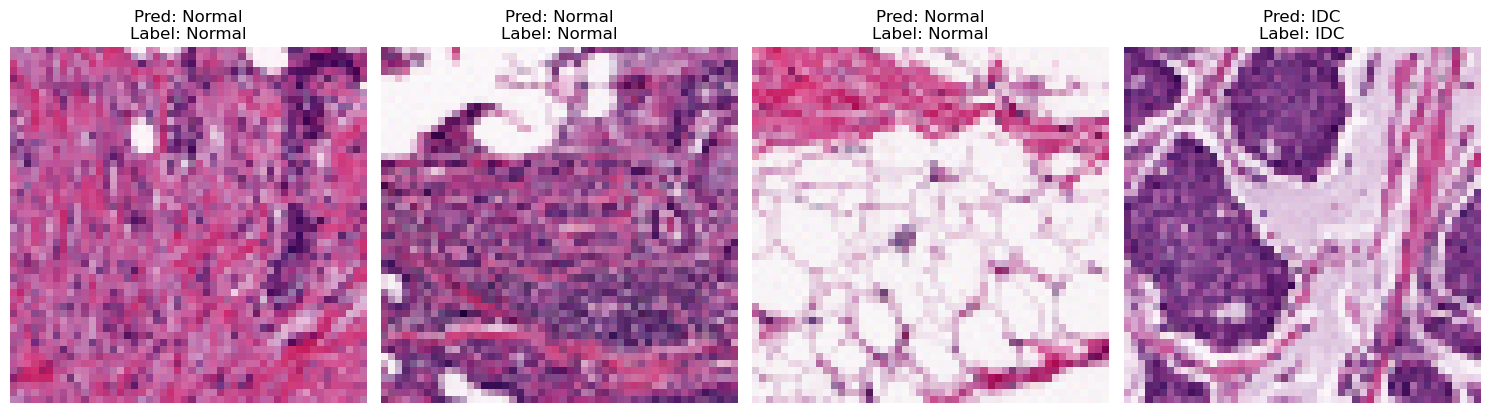

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = "histopathology_images/"

transform = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

#Dataset Class
class CancerTileDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        #Traverse the folder structure
        for patient_id in os.listdir(img_dir):
            patient_path = os.path.join(img_dir, patient_id)
            if not os.path.isdir(patient_path):  #Skip files if any
                continue
            
            for label_folder in ["0", "1"]:  #Non-IDC (0) and IDC (1)
                label_path = os.path.join(patient_path, label_folder)
                if not os.path.exists(label_path):
                    continue

                #Gather image files
                for img_name in os.listdir(label_path):
                    if img_name.endswith(".png"):  
                        img_path = os.path.join(label_path, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(int(label_folder))  #0 or 1

        print(f"Dataset Loaded: {len(self.image_paths)} images found.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]  #0 = Non-IDC, 1 = IDC

        #Open image
        image = Image.open(img_path).convert("RGB")

        #Apply transformation
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

#Load Dataset
dataset = CancerTileDataset(data_dir, transform=transform)

#Split dataset into train (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#CNN Model for IDC Tile Classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 6 * 6, 128)  
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)  #Flatten
        x = torch.relu(self.fc1(x))
        return self.sigmoid(self.fc2(x))

#Initialize Model
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += ((outputs > 0.5).float() == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}")

    print("Training Complete.")

#Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer)

#Visualization Function
def visualize_predictions(model, val_loader, num_images=4):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    images, labels = next(iter(val_loader))

    for i in range(num_images):
        img, label = images[i], labels[i]
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor).item()
        prediction = "IDC" if output > 0.5 else "Normal"

        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())

        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {prediction}\nLabel: {'IDC' if label == 1 else 'Normal'}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader)

### Implement Model with the Entire Set of Images - Denote IDC Predictions

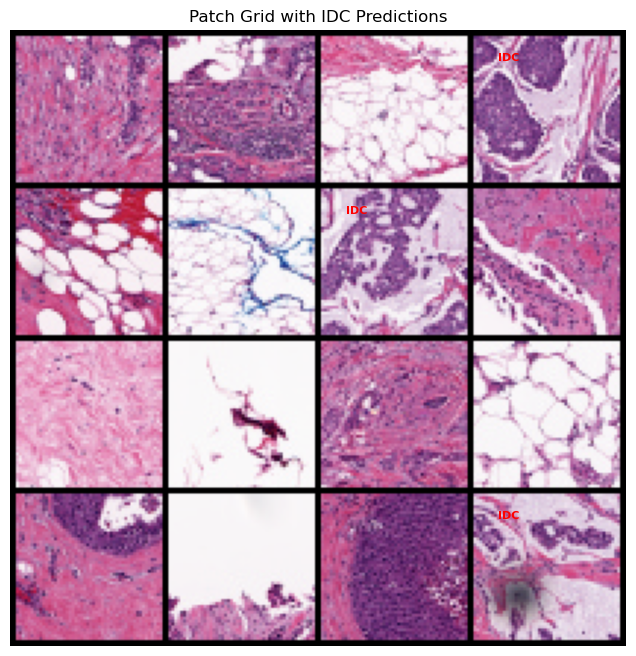

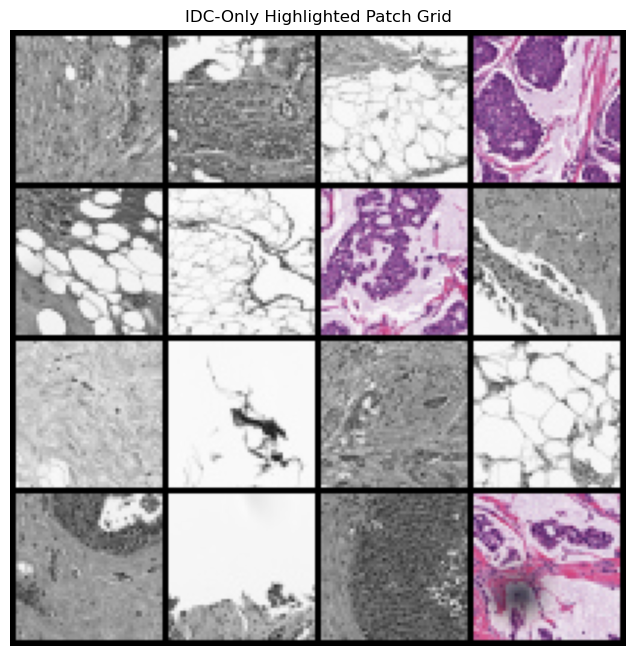

In [ ]:
#Visualize a 7x7 Patch Grid with Predictions
def visualize_patch_grid(model, val_loader, max_grid_size=7):
    model.eval()
    
    #Batch of validation images
    images, labels = next(iter(val_loader))
    
    batch_size = images.shape[0]
    grid_size = min(max_grid_size, int(np.sqrt(batch_size)))  #Adjust grid dynamically
    num_patches = grid_size ** 2  #Total number of patches to visualize

    images, labels = images[:num_patches], labels[:num_patches]  #Select available images
    predictions = []

    for img in images:
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor).item()
        predictions.append(output > 0.5)  #Boolean prediction: True = IDC, False = Normal

    images = images.cpu()
    img_grid = make_grid(images, nrow=grid_size, padding=2, normalize=True).permute(1, 2, 0)

    #Plot original images with predictions
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_grid)
    ax.set_title("Patch Grid with IDC Predictions")
    ax.axis("off")

    #Overlay IDC predictions
    patch_size = img_grid.shape[0] // grid_size 
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            if idx < len(predictions) and predictions[idx]:  
                ax.text(j * patch_size + 10, i * patch_size + 10, "IDC", color="red", fontsize=8, weight="bold")

    plt.savefig("patch_classification_grid.png")
    plt.show()

    img_grid_np = img_grid.numpy().copy()
    
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            if idx < len(predictions) and not predictions[idx]:  #If NOT IDC, desaturate
                img_patch = img_grid_np[i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                grayscale_patch = np.mean(img_patch, axis=-1, keepdims=True)  #Convert to grayscale
                img_grid_np[i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size] = np.repeat(grayscale_patch, 3, axis=-1)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_grid_np)
    ax.set_title("IDC-Only Highlighted Patch Grid")
    ax.axis("off")
    plt.show()

visualize_patch_grid(model, val_loader)